In [31]:
!pip install pmdarima

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./owid-covid-data.csv', index_col='date', parse_dates = True)
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,ZWE,Africa,Zimbabwe,133836.0,0.0,31.571,4704.0,0.0,0.714,8867.909,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2021-11-28,ZWE,Africa,Zimbabwe,133951.0,115.0,43.429,4705.0,1.0,0.857,8875.529,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2021-11-29,ZWE,Africa,Zimbabwe,134226.0,275.0,78.857,4706.0,1.0,1.000,8893.750,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [18]:
#Выведем названия всех стран
df.location.value_counts().index

Index(['Peru', 'Mexico', 'Argentina', 'Thailand', 'Taiwan', 'South Korea',
       'North America', 'World', 'High income', 'Lower middle income',
       ...
       'Tuvalu', 'Cook Islands', 'Nauru', 'Bonaire Sint Eustatius and Saba',
       'Tokelau', 'Palau', 'Saint Helena', 'Pitcairn', 'Falkland Islands',
       'Niue'],
      dtype='object', length=237)

In [4]:
#Получим краткую сводку данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137176 entries, 2020-02-24 to 2021-12-01
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    137176 non-null  object 
 1   continent                                   128442 non-null  object 
 2   location                                    137176 non-null  object 
 3   total_cases                                 129550 non-null  float64
 4   new_cases                                   129545 non-null  float64
 5   new_cases_smoothed                          128505 non-null  float64
 6   total_deaths                                118273 non-null  float64
 7   new_deaths                                  118469 non-null  float64
 8   new_deaths_smoothed                         128505 non-null  float64
 9   total_cases_per_million                     128886 non

<AxesSubplot:xlabel='date'>

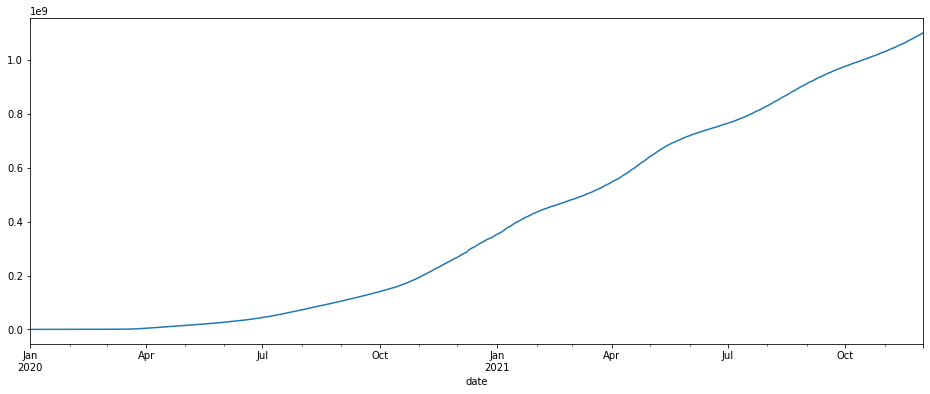

In [6]:
#Посмотрим как коронавирус распространялся с течением времени.
plt.figure(figsize=(16,6))
df.groupby('date').sum()['total_cases'].plot()

In [ ]:
#Видим, что со временем наблюдается  рост числа жертв коронавируса

In [7]:
#разведочный анализ данных
df.groupby('continent').sum()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
continent,,,,,,,,,,,,,,,,,,,,,
Africa,2.240704e+09,8646847.0,8.621277e+06,57271155.0,223037.0,222629.179,1.894550e+08,867820.094,864034.267,3.128931e+06,...,58157.8,618695.8,698690.081,37797.580,2176036.31,18629.591,9707534.8,1069.88,2637.95,1.282136e+05
Asia,1.928857e+10,81377583.0,8.112019e+07,290587408.0,1220319.0,1216168.929,5.375234e+08,2306196.555,2294432.176,5.515057e+06,...,118281.4,978562.2,1160955.624,82485.330,2314171.46,22232.282,11176887.9,5033.02,10069.10,2.966374e+05
Europe,1.791880e+10,75521443.0,7.441237e+07,414315291.0,1424536.0,1412665.351,1.315492e+09,5531806.351,5441421.360,2.425041e+07,...,608930.7,924357.6,180066.909,144149.447,2405598.57,24047.981,50491694.9,16951.12,35933.42,2.448547e+06
North America,1.585261e+10,58239889.0,5.787171e+07,364937053.0,1167101.0,1162305.056,2.580976e+08,1313253.064,1305187.966,5.186049e+06,...,58843.7,172066.3,641797.047,33767.560,1328920.92,11071.740,61934258.5,4893.60,9004.20,3.697158e+05
Oceania,3.861923e+07,313067.0,3.081829e+05,641489.0,3309.0,3284.776,9.155535e+06,73245.493,72816.368,1.112986e+05,...,64027.1,133143.6,57686.923,9665.470,481386.28,3673.565,-284845.8,-475.37,46.60,-3.240298e+04
South America,1.117677e+10,38810788.0,3.875805e+07,353063119.0,1169411.0,1168190.536,2.294315e+08,880278.594,878533.344,7.573470e+06,...,64296.5,127499.8,251011.856,16199.940,588004.95,5925.089,28969177.1,17334.91,21815.14,8.311811e+05


In [8]:
#Найдём страны, в которых  нет зарегистрированных жертв коронавируса
df[df['total_deaths']==0]
#Видим,что страны, в которых нет погибших от коронавируса отсутствуют

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,


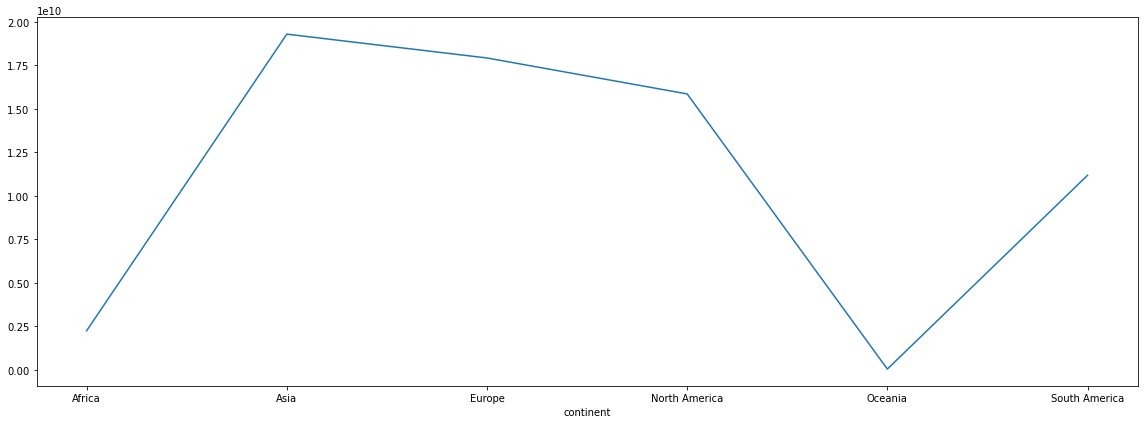

In [9]:
#Посмотрим на количество зараженных на разных континентах
plt.figure(figsize=(16,6))
df.groupby('continent').sum()['total_cases'].plot()
plt.tight_layout()

In [ ]:
#На графике видим, что больше всего вирус затронул страны Азии. И в меньшей степени страны Океании и Африки

<AxesSubplot:xlabel='date'>

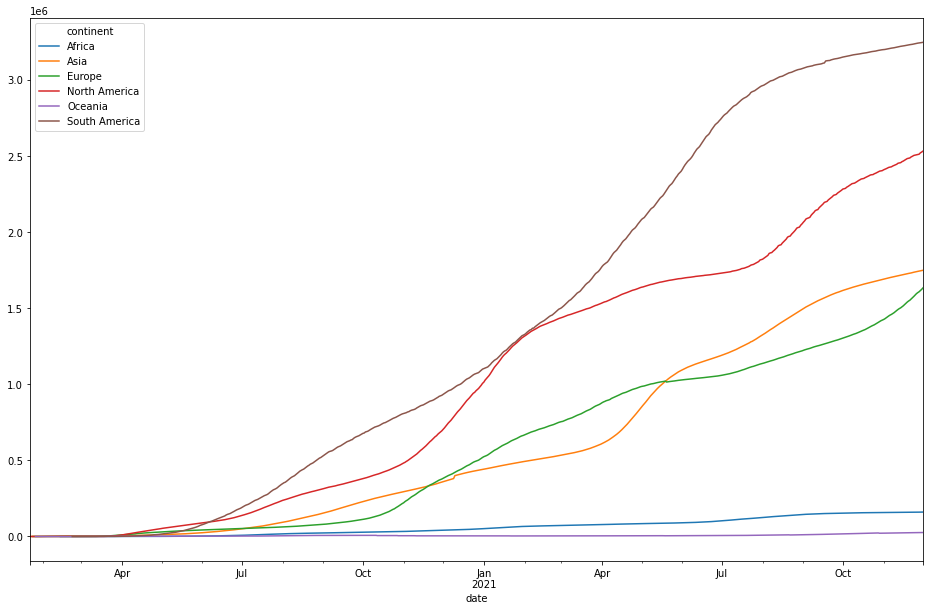

In [10]:
#Анализ роста коронавируса с течением времени на каждом континенте
pivoted = pd.pivot_table(df, values='total_cases', columns='continent', index='date')
pivoted.plot(figsize=(16,10))

In [ ]:
#На графике видно, что наиболее высокие показатели в странах Южной и Северной Америки. 
#Самые низкие показатели в странах Африки и Океании

In [11]:
#Где произошло большинство смертей
df.groupby('continent')['total_deaths'].sum().reset_index().sort_values(by=['total_deaths'],ascending=False).head()

,continent,total_deaths
2,Europe,414315291.0
3,North America,364937053.0
5,South America,353063119.0
1,Asia,290587408.0
0,Africa,57271155.0


In [ ]:
#Видим, что наибольшее количество смертей произошло в Европе. Наименьшее количество в Африке.

In [14]:
#Выведем данные для России
df1 = df[df.location=='Russia']
df1

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,RUS,Europe,Russia,2.0,2.0,NaN,NaN,NaN,NaN,0.014,...,23.4,58.3,NaN,8.05,72.58,0.824,-5538.0,-3.33,-3.33,-37.954378
2020-02-01,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2020-02-02,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2020-02-03,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2020-02-04,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,RUS,Europe,Russia,9370694.0,33119.0,33649.286,266337.0,1203.0,1206.571,64221.535,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2021-11-28,RUS,Europe,Russia,9403480.0,32786.0,33226.000,267527.0,1190.0,1202.857,64446.232,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
2021-11-29,RUS,Europe,Russia,9436650.0,33170.0,33031.286,268705.0,1178.0,1198.000,64673.561,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [16]:
#выведем характеристики датасета
df1.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,6.710000e+02,671.000000,666.000000,623.000000,623.000000,666.000000,671.000000,671.000000,666.000000,623.000000,...,6.710000e+02,6.710000e+02,0.0,6.710000e+02,6.710000e+02,6.710000e+02,22.000000,22.000000,22.000000,22.000000
mean,3.301101e+06,14159.219076,14118.750766,84201.521669,435.138042,401.679102,22623.913776,97.039440,96.762087,577.070494,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,327264.209091,14.141364,27.224091,2242.887218
std,2.762386e+06,10072.427849,9978.382607,76068.609129,317.759384,320.737093,18931.860915,69.030836,68.386298,521.332026,...,2.488755e-13,4.266437e-14,NaN,9.955019e-14,1.137716e-12,4.999731e-15,282783.870515,9.854967,21.526587,1938.043669
min,2.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.014000,0.000000,0.000000,0.007000,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,-5538.000000,-3.330000,-3.330000,-37.954378
25%,7.548065e+05,6559.500000,6582.035500,16208.000000,153.000000,125.642500,5173.024500,44.955000,45.109750,111.080500,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,58291.300000,6.112500,14.412500,399.496211
50%,3.127347e+06,10559.000000,10491.928500,68397.000000,387.000000,370.357500,21433.100000,72.366000,71.906000,468.755000,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,330828.750000,19.285000,21.525000,2267.316603
75%,5.196188e+06,21729.000000,21778.393000,131992.500000,633.000000,547.142500,35611.791500,148.918500,149.257250,904.603500,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,520675.425000,21.965000,46.665000,3568.420325
max,9.500836e+06,40210.000000,39354.286000,271091.000000,1222.000000,1217.571000,65113.456000,275.577000,269.712000,1857.907000,...,2.340000e+01,5.830000e+01,NaN,8.050000e+00,7.258000e+01,8.240000e-01,870843.400000,26.850000,70.440000,5968.277240


<AxesSubplot:xlabel='date'>

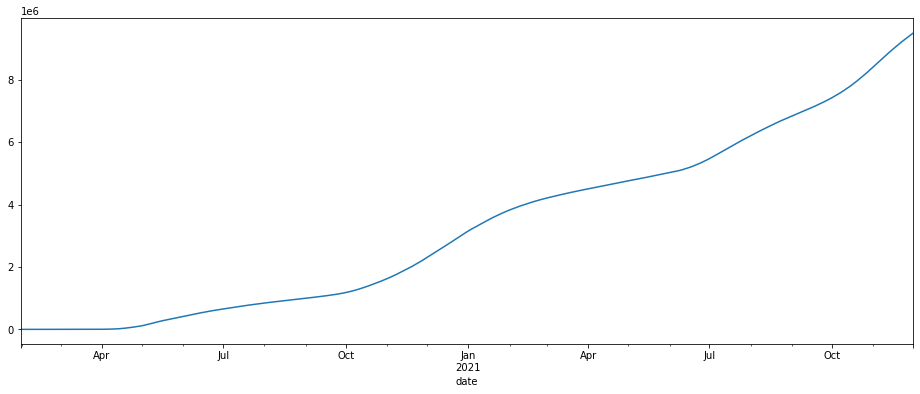

In [15]:
#Посмотрим как коронавирус распространялся в России с течением времени.
plt.figure(figsize=(16,6))
df1.groupby('date').sum()['total_cases'].plot()

In [ ]:
# Наблюдаем,  что с апреля 2020 г. по октябрь 2021 произошел рост числа заболевших

In [17]:
#Выведем список всех столбцов
list(df1)

['iso_code',
 'continent',
 'location',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully

In [22]:
df1['date']=pd.to_datetime
df1.head()

C:\Users\99F8~1\AppData\Local\Temp/ipykernel_74700/3620128498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date']=pd.to_datetime


,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,date
date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,RUS,Europe,Russia,2.0,2.0,NaN,NaN,NaN,NaN,0.014,...,58.3,NaN,8.05,72.58,0.824,-5538.0,-3.33,-3.33,-37.954378,<function to_datetime at 0x00000126417C94C0>
2020-02-01,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,<function to_datetime at 0x00000126417C94C0>
2020-02-02,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,<function to_datetime at 0x00000126417C94C0>
2020-02-03,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,<function to_datetime at 0x00000126417C94C0>
2020-02-04,RUS,Europe,Russia,2.0,0.0,NaN,NaN,NaN,NaN,0.014,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,<function to_datetime at 0x00000126417C94C0>


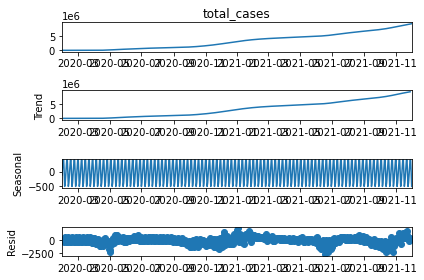

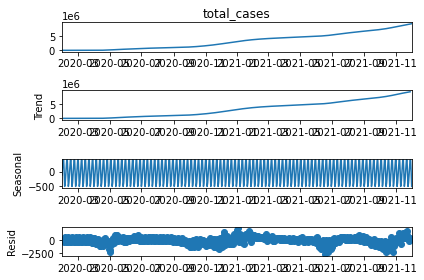

In [30]:
#ETS декомпозиция
#Используем аддитивную модель ('additive').
result = seasonal_decompose(df1['total_cases'], model='add')
result.plot()

In [ ]:
#Видно, что существует определенная сезонность

In [35]:
#Запускаем pmdarima.auto_arima
# m=12
auto_arima(df1['total_cases'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  671
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 12)   Log Likelihood               -5279.550
Date:                             Sun, 26 Dec 2021   AIC                          10571.100
Time:                                     13:31:47   BIC                          10598.134
Sample:                                          0   HQIC                         10581.572
                                             - 671                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2440      0.008    163.627      0.000       1.229       1.259
ar.L2         -0.9942      0.007   -136.391      0.000      -1.009      -0.980
ma.L1         -1.2499      0.018    -69.108      0.000      -1.285      -1.214
ma.L2          0.9653      0.018     52.676      0.000       0.929       1.001
ar.S.L12       0.0265      0.039      0.675      0.499      -0.050       0.104
sigma2      4.778e+05   2.03e+04     23.578      0.000    4.38e+05    5.17e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.44   Jarque-Bera (JB):               290.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.99   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
#делим на train/test
len(df1)

671

In [40]:
train = df1.iloc[:659]
test = df1.iloc[659:] #Берём последние 12 точек для теста

In [42]:
# Обучаем SARIMA (2, 2, 2)x(1, 0, [], 12)
model = SARIMAX(train['total_cases'], order=(2, 2, 2), seasonal_order=(1, 0,[], 12) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         total_cases   No. Observations:                  659
Model:             SARIMAX(2, 2, 2)x(1, 0, [], 12)   Log Likelihood               -5211.714
Date:                             Sun, 26 Dec 2021   AIC                          10435.427
Time:                                     13:53:34   BIC                          10462.353
Sample:                                 01-31-2020   HQIC                         10445.866
                                      - 11-19-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4359      0.016    -28.118      0.000      -0.466      -0.406
ar.L2         -0.9777      0.016    -61.576      0.000      -1.009      -0.947
ma.L1          0.3851      0.024     15.731      0.000       0.337       0.433
ma.L2          0.9331      0.026     35.804      0.000       0.882       0.984
ar.S.L12       0.0942      0.034      2.767      0.006       0.027       0.161
sigma2      4.767e+05   1.83e+04     25.986      0.000    4.41e+05    5.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               297.44
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               5.39   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# предсказанные значения
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2, 2, 2)x(1, 0, [], 12)')

In [44]:
# Сравниваем результаты
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['total_cases'][i]}")

predicted=9134811.803, expected=9135149.0
predicted=9170833.184, expected=9170898.0
predicted=9206927.339, expected=9205431.0
predicted=9242721.602, expected=9238330.0
predicted=9278523.697, expected=9270885.0
predicted=9314754.433, expected=9303751.0
predicted=9350653.439, expected=9337575.0
predicted=9386140.623, expected=9370694.0
predicted=9421923.112, expected=9403480.0
predicted=9457857.605, expected=9436650.0
predicted=9493351.604, expected=9468640.0
predicted=9528880.545, expected=9500836.0


In [ ]:
#Видно, что предсказанные и ожидаемые результаты похожи по значению

[Text(0.5, 0, 'date'), Text(0, 0.5, '')]

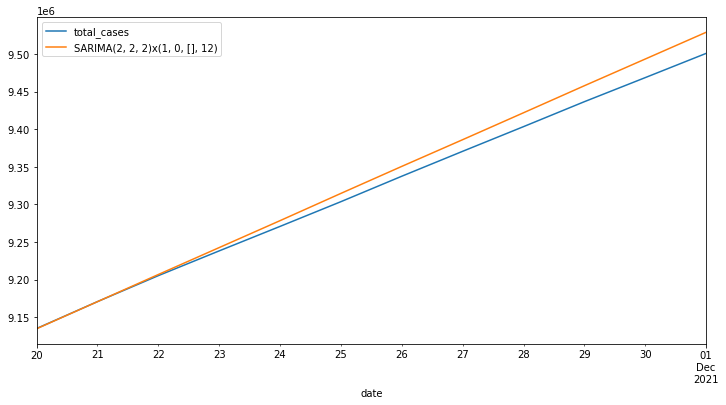

In [45]:
#Построим график для тестового множества
ylabel=''
xlabel='date'

ax = test['total_cases'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [47]:
#Оценка модели
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['total_cases'], predictions)
print(f'SARIMA(2, 2, 2)x(1, 0, [], 12)) MSE Error: {error:11.10}')

SARIMA(2, 2, 2)x(1, 0, 0, 12)) MSE Error: 233148569.1


In [48]:
from statsmodels.tools.eval_measures import rmse
# rmse = root mse
error = rmse(test['total_cases'], predictions)
print(f'SARIMA(2, 2, 2)x(1, 0, [], 12) RMSE Error: {error:11.10}')

SARIMA(2, 2, 2)x(1, 0, [], 12) RMSE Error: 15269.20329


In [65]:
#Обучаем модель  и прогнозируем будущее
# (2, 2, 2)x(1, 0, [], 12)
model = SARIMAX(df1['total_cases'],order=(2, 2, 2),seasonal_order=(1, 0, [], 12))
results = model.fit()

fcast = results.predict(len(df1),len(df1)+11,typ='levels').rename('SARIMA(2, 2, 2)x(1, 0, [], 12) Forecast')

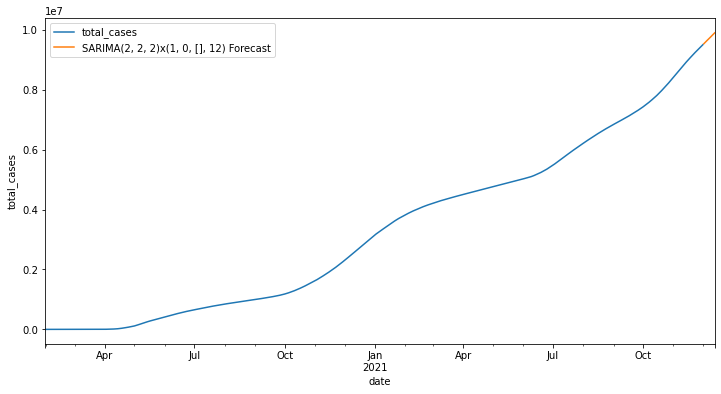

In [66]:
# график

ylabel='total_cases'
xlabel='date'

ax = df1['total_cases'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);



<AxesSubplot:>

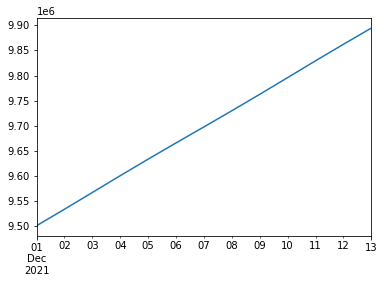

In [68]:
#Строим график предсказаний 
fcast.plot()

In [ ]:
#На графике видно, что в ближайшие 11 месяцев будет наблюдаться рост  числа заболеваний